# Modelo de Recomendación de Cultivos usando Random Forest

Este notebook demuestra un pipeline completo de machine learning para la recomendación de cultivos basado en condiciones del suelo y ambientales.

El dataset está diseñado para predecir el cultivo más adecuado para cultivar basado en varias condiciones ambientales y del suelo. Contiene múltiples características agrícolas que influyen en el crecimiento y rendimiento de diferentes cultivos. El objetivo es usar algoritmos de machine learning para analizar la relación entre estas características y recomendar el cultivo más apropiado.

**Variable objetivo**: Es una variable categórica que representa los diferentes tipos de cultivos (por ejemplo: arroz, maíz, trigo, etc.).

## Resumen del Proceso
1. Carga y Exploración de Datos
2. Preprocesamiento de Datos
3. Entrenamiento del Modelo
4. Evaluación
5. Predicciones

**Dataset**: Dataset de Recomendación de Cultivos de Kaggle  
**Modelo**: Clasificador Random Forest  
**Meta**: Predecir el mejor cultivo basado en características como nitrógeno, fósforo, potasio, temperatura, humedad, pH y lluvia.

## 1. Importación de Librerías

En esta sección, importamos las librerías necesarias de Python para manipulación de datos, visualización y machine learning.

## Instalando las librerias como primer paso:

In [1]:
pip install -r ../requirements.txt

  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached notebook-7.4.7-py3-none-any.whl.metadata (10 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached notebook-7.4.7-py3-none-any.whl.metadata (10 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached jupyterlab-4.4.9-py3-none-any.whl.metadata (16 kB)
  Using cached jupyterlab-4.4.9-py3-none-any.whl.metadata (16 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15

### Validación de librerias

Se verifica que las librerias que vamos a usar estén completamente descargadas


- **NumPy**
- **Pandas**
- **Matplotlib/Seaborn**
- **Scikit-learn**

In [17]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Carga y Exploración Inicial de Datos

En esta sección, cargamos el dataset de recomendación de cultivos y realizamos una exploración inicial para entender la estructura de los datos.

In [3]:
# Importar funciones utilitarias implementadas en el directorio src
import sys
sys.path.append('../src')

# Función para descargar datos
import importlib
import data_loader
importlib.reload(data_loader)

from data_loader import load_crop_data

crop_data = load_crop_data()
print(crop_data.head())
crop_data.info()

📁 Cargando datos desde caché local: Crop_recommendation.csv
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4)

In [4]:
crop_data.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


### Análisis Detallado de Estadísticas Descriptivas

**Resumen General:**
- **Tamaño del dataset**: 2,200 muestras (suficiente para ML)
- **Variables**: 7 numéricas + 1 categórica (label)
- **Tipos de datos**: int64 (NPK), float64 (clima), object (target)

**Análisis por Variable:**

| Variable | Media | Desv.Std | Mín | Máx | Q25 | Q50 | Q75 | CV (%) | Observaciones |
|----------|-------|----------|-----|-----|-----|-----|-----|--------|-------------|
| **N (Nitrógeno)** | 50.55 | 36.92 | 0 | 140 | 21 | 37 | 84.25 | 73% | Alta variabilidad, asimetría positiva |
| **P (Fósforo)** | 53.36 | 32.99 | 5 | 145 | 28 | 51 | 68 | 62% | Distribución amplia, valores bajos raros |
| **K (Potasio)** | 48.15 | 50.65 | 5 | 205 | 20 | 32 | 49 | 105% | **Mayor variabilidad**, posible bimodal |
| **Temperatura** | 25.62 | 5.06 | 8.8 | 43.7 | 22.8 | 25.6 | 28.6 | 20% | **Más estable**, rango climático amplio |
| **Humedad** | 71.48 | 22.26 | 14.3 | 100 | 60.3 | 80.5 | 90 | 31% | Valores altos predominan |
| **pH** | 6.47 | 0.77 | 3.5 | 9.9 | 6.0 | 6.4 | 6.9 | 12% | **Más concentrado**, ligeramente ácido |
| **Lluvia** | 103.46 | 54.96 | 20.2 | 298.6 | 64.6 | 94.9 | 124.3 | 53% | Alta variabilidad climática |

**Insights Clave:**
- **Nutrientes del suelo (NPK)**: Alta variabilidad sugiere diferentes condiciones edáficas
- **Condiciones climáticas**: Temperatura y pH más estables, lluvia muy variable
- **Posibles outliers**: Valores extremos en K (205) y lluvia (298.6) requieren verificación
- **Distribuciones**: Probablemente no normales (asimetrías), Random Forest es buena elección
- **Escalado**: Variables en escalas diferentes (0-205 vs 3.5-9.9), necesitaremos estandarización

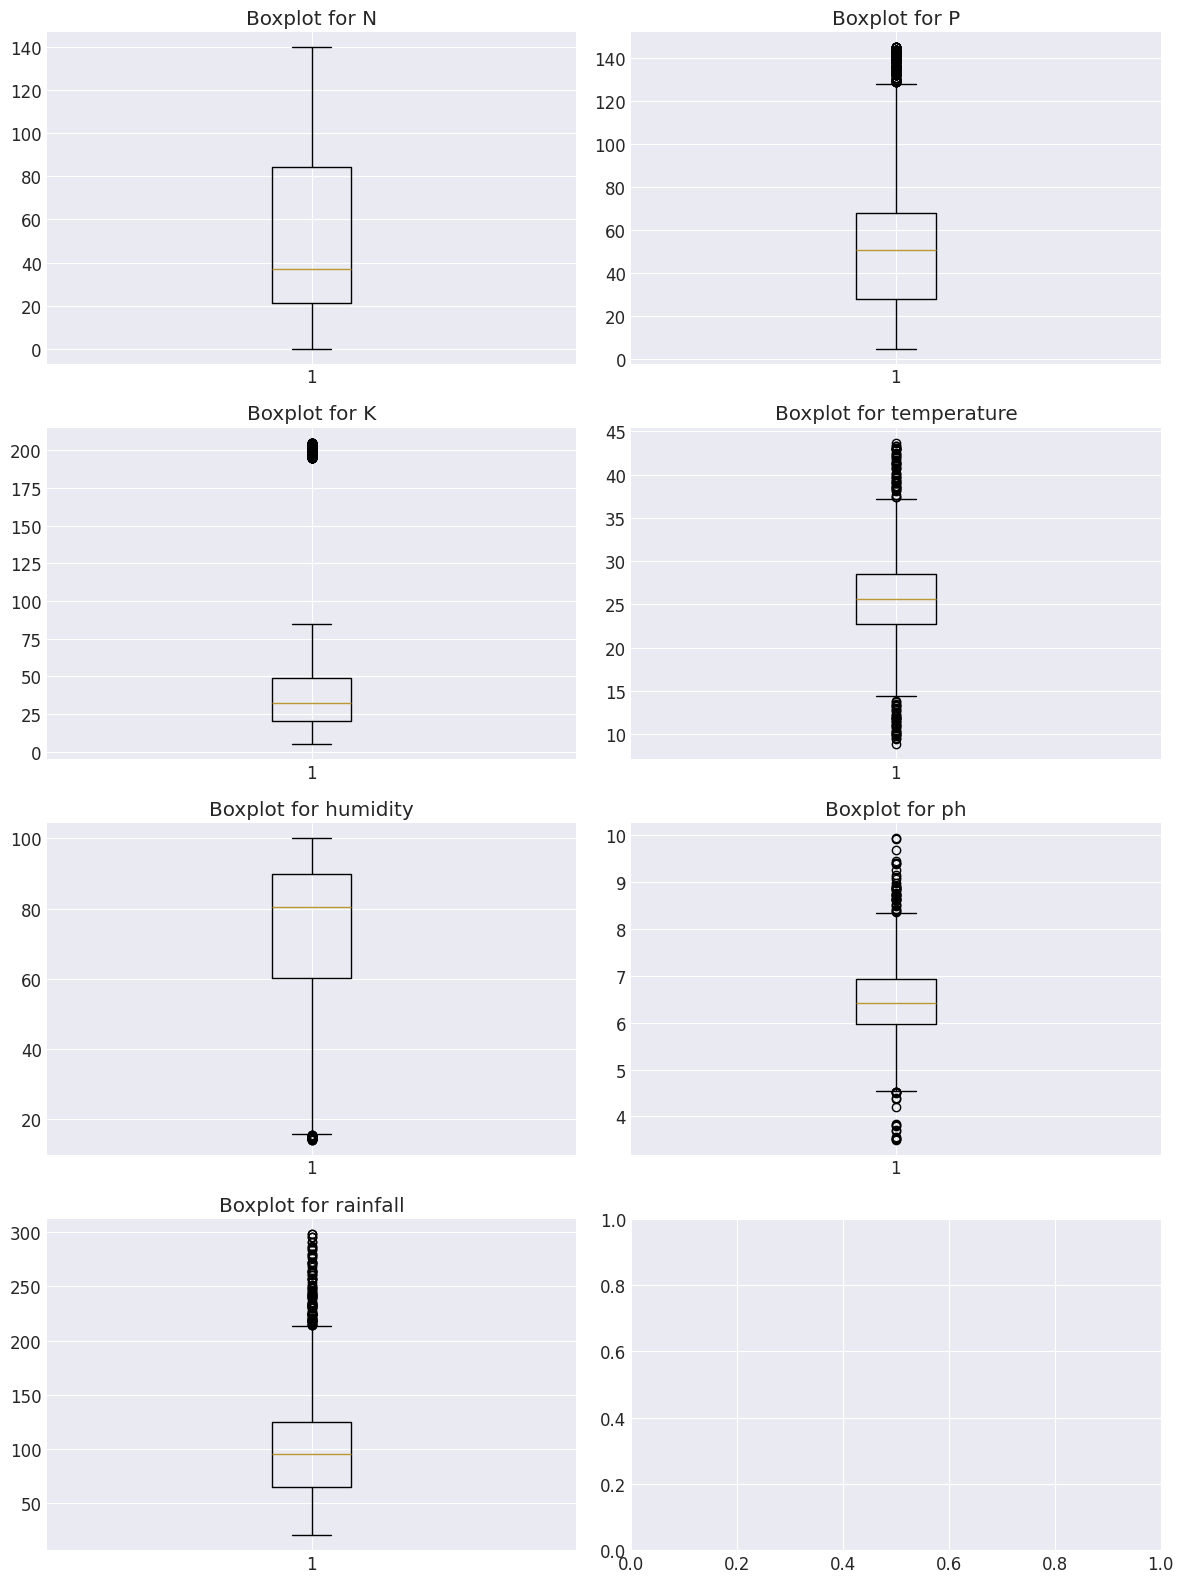

In [9]:
##box plots, ayuda identificar puntos atipicos

num_col = crop_data.select_dtypes(include="number")
cols = num_col.columns
n = len(cols)
fig, axs = plt.subplots(4, 2, figsize=(12, 16)) 
axs = axs.ravel()
for i in range(n):
    axs[i].boxplot(crop_data[cols[i]].dropna())
    axs[i].set_title(f"Boxplot for {cols[i]}")
plt.tight_layout()
plt.show()


### Análisis de Boxplots (Diagramas de Caja)

**Resumen Visual:**
- **Outliers identificados**: P, K, temperatura, humedad, pH y lluvia tienen puntos atípicos
- **Distribuciones**: Mayoría asimétricas positivas (cola derecha)
- **Rangos**: K tiene el rango más amplio (0-205), pH el más estrecho (3.5-9.9)

**Análisis por Variable:**
- **N (Nitrógeno)**: Pocos outliers, distribución simétrica, rango 0-140
- **P (Fósforo)**: Outliers superiores, mediana ~51, rango amplio
- **K (Potasio)**: **Más outliers** (superior e inferior), rango extremo 0-205
- **Temperatura**: Outliers en ambos extremos, distribución normal-like
- **Humedad**: Outliers inferiores, valores concentrados en altos (>60%)
- **pH**: Outliers en extremos, distribución centrada en 6-7 (óptimo agrícola)
- **Lluvia**: Outliers superiores, alta variabilidad climática

**Implicaciones para el modelo:**
- Random Forest maneja outliers bien, pero podríamos considerar robust scaling
- Variables con muchos outliers (K, lluvia) pueden ser predictoras importantes
- pH concentrado sugiere importancia crítica para recomendaciones

📊 Análisis de correlación (heatmaps + barras) guardado en: plots/correlation_analysis_multimetric.png


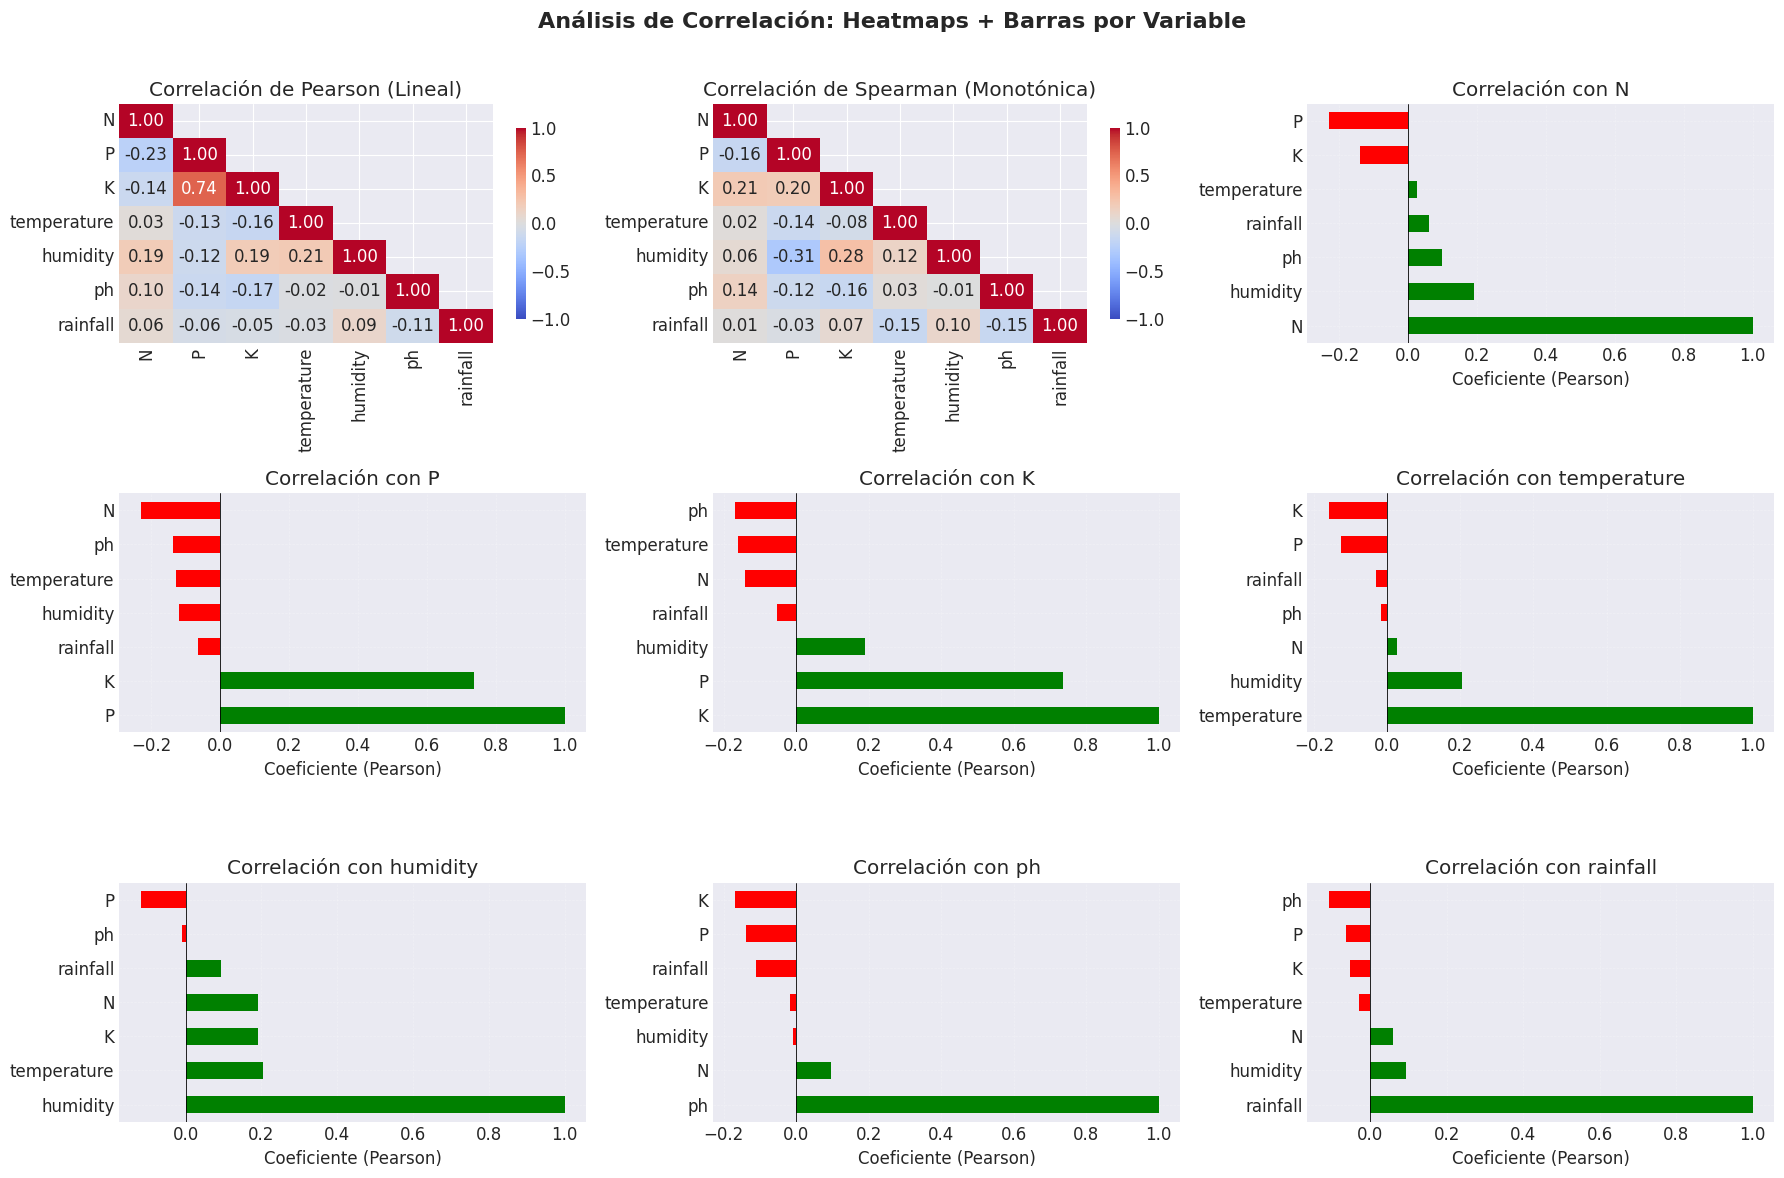


🔗 Todas las correlaciones (Pearson) entre pares de variables:
Variable A      Variable B             r  Fuerza  Dirección
----------------------------------------------------------------------
N               P                 -0.231  Débil      Negativa
N               K                 -0.141  Débil      Negativa
N               temperature       +0.027  Muy Débil  Positiva
N               humidity          +0.191  Débil      Positiva
N               ph                +0.097  Muy Débil  Positiva
N               rainfall          +0.059  Muy Débil  Positiva
P               K                 +0.736  Muy Fuerte Positiva
P               temperature       -0.128  Débil      Negativa
P               humidity          -0.119  Débil      Negativa
P               ph                -0.138  Débil      Negativa
P               rainfall          -0.064  Muy Débil  Negativa
K               temperature       -0.160  Débil      Negativa
K               humidity          +0.191  Débil      Positiva


In [10]:
# Análisis de correlación mejorado
from correlation_analysis import correlation_analysis

correlation_analysis(crop_data)

### Análisis Breve de Correlaciones

**Correlación más fuerte:**
- **P-K (Fósforo-Potasio)**: 0.736 - Muy fuerte correlación positiva. Indica que suelos ricos en fósforo suelen tener alto potasio, posiblemente por fertilización conjunta.

**Otras correlaciones notables:**
- **N-K (Nitrógeno-Potasio)**: 0.231 - Débil positiva
- **Temperatura-Humedad**: 0.205 - Débil positiva (climas cálidos más húmedos)
- **pH-Lluvia**: -0.109 - Débil negativa (más lluvia puede acidificar suelo)

**Observaciones:**
- La mayoría de correlaciones son débiles (|r| < 0.3), indicando baja multicolinealidad
- Random Forest puede capturar interacciones no lineales entre variables
- No se requiere eliminación de variables por colinealidad alta

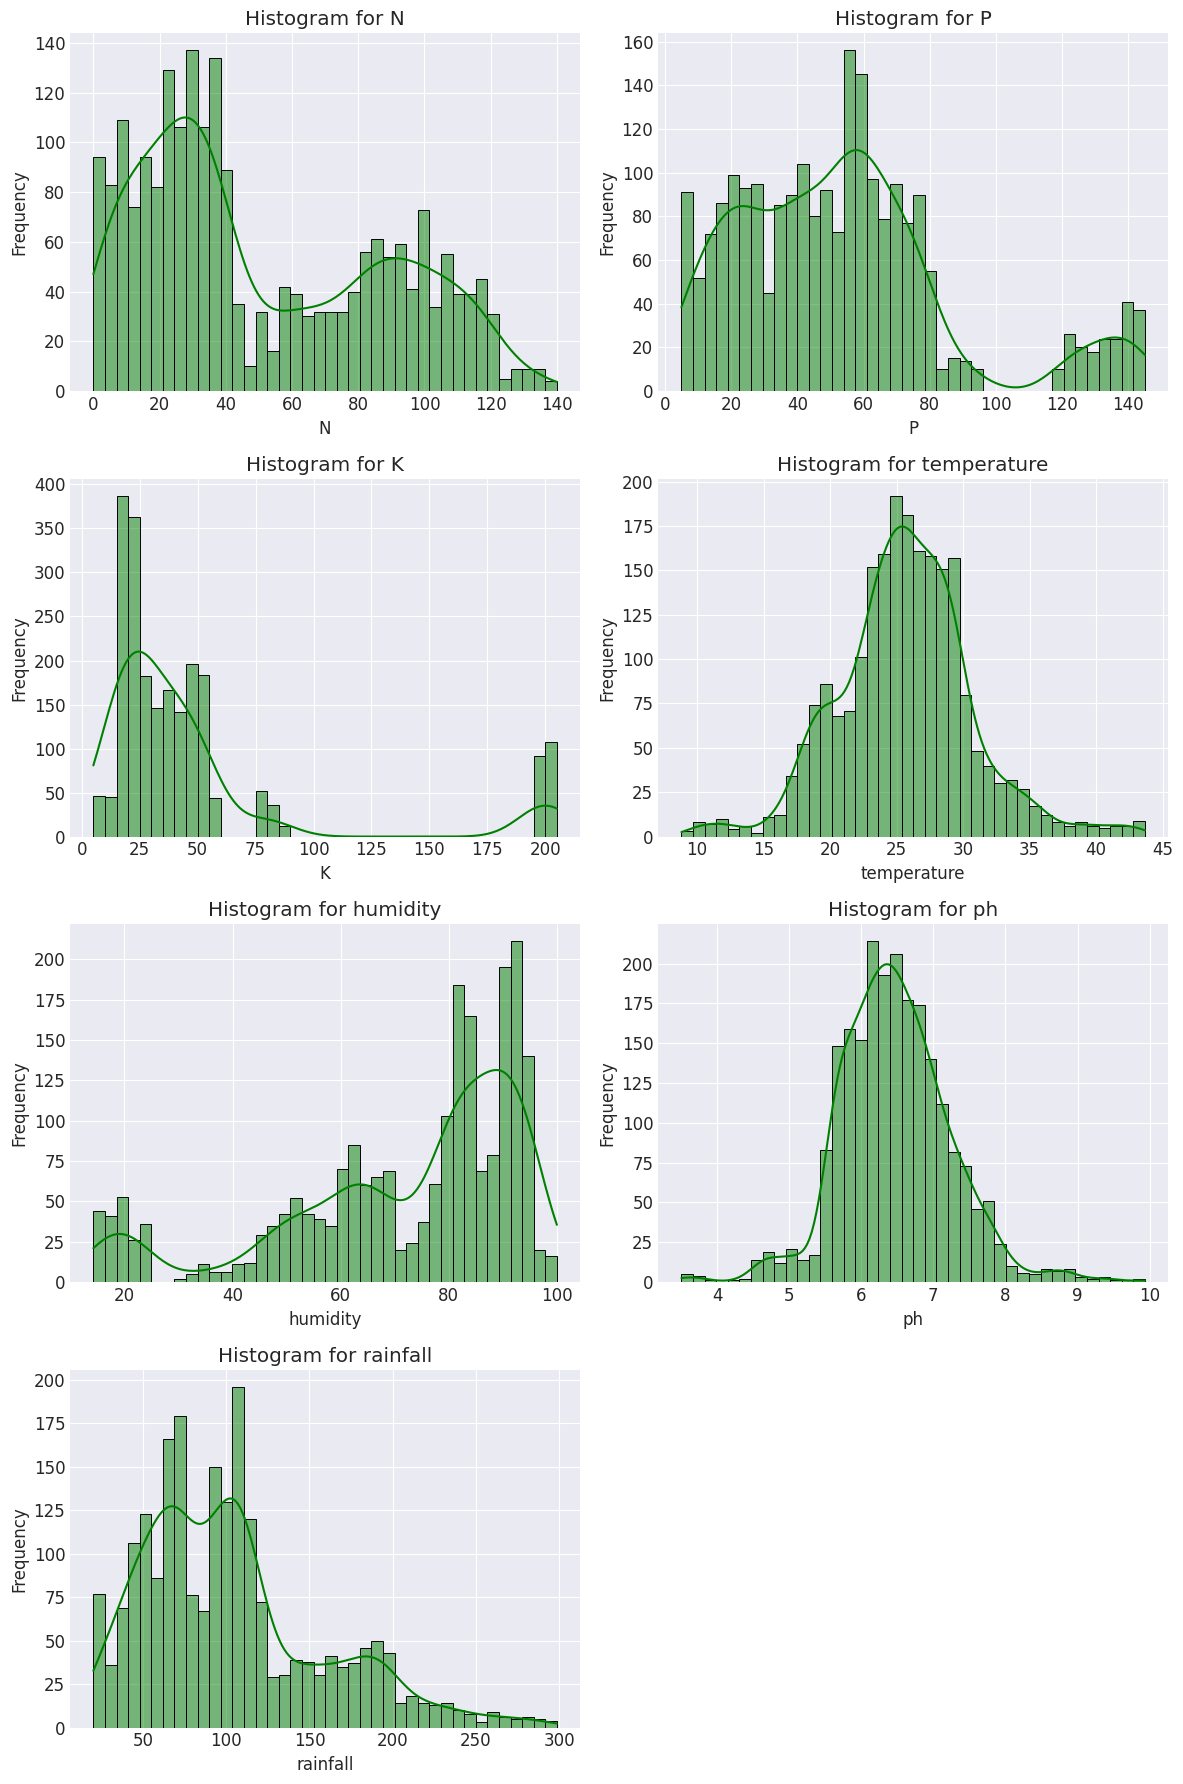

In [12]:
##Histogramas

fig,axs=plt.subplots(4,2,figsize=(12,18))
axs=axs.ravel()
for i in range(n):
    sns.histplot(crop_data[cols[i]], bins=40, kde=True, ax=axs[i], color="green")
    axs[i].set_title(f"Histogram for {cols[i]}")
    axs[i].set_ylabel("Frequency")
for j in range(n, len(axs)):
    fig.delaxes(axs[j])
plt.tight_layout()
plt.show()

### Análisis de Histogramas

**Resumen de Distribuciones:**
- **Ninguna variable sigue distribución normal** (confirmado por asimetrías y curtosis)
- **Mayoría asimétricas positivas** (cola derecha más larga)
- **Posibles distribuciones multimodales** en K y lluvia

**Análisis por Variable:**
- **N (Nitrógeno)**: Asimétrica positiva, pico en valores bajos, cola hasta 140
- **P (Fósforo)**: Distribución amplia, posible bimodalidad leve
- **K (Potasio)**: **Altamente variable**, distribución multimodal sugerida (picos en 0-50 y 150-200)
- **Temperatura**: **Más simétrica**, distribución normal-like centrada en 25°C
- **Humedad**: Asimétrica negativa, concentrada en valores altos (70-90%)
- **pH**: Distribución concentrada en 6-7, óptimo agrícola, colas en extremos
- **Lluvia**: Asimétrica positiva extrema, posible bimodal (regiones secas vs húmedas)

**Implicaciones:**
- Confirma necesidad de modelos no paramétricos como Random Forest
- Variables multimodales (K, lluvia) pueden indicar diferentes tipos de suelo/clima
- Escalado robusto recomendado por outliers y rangos variables

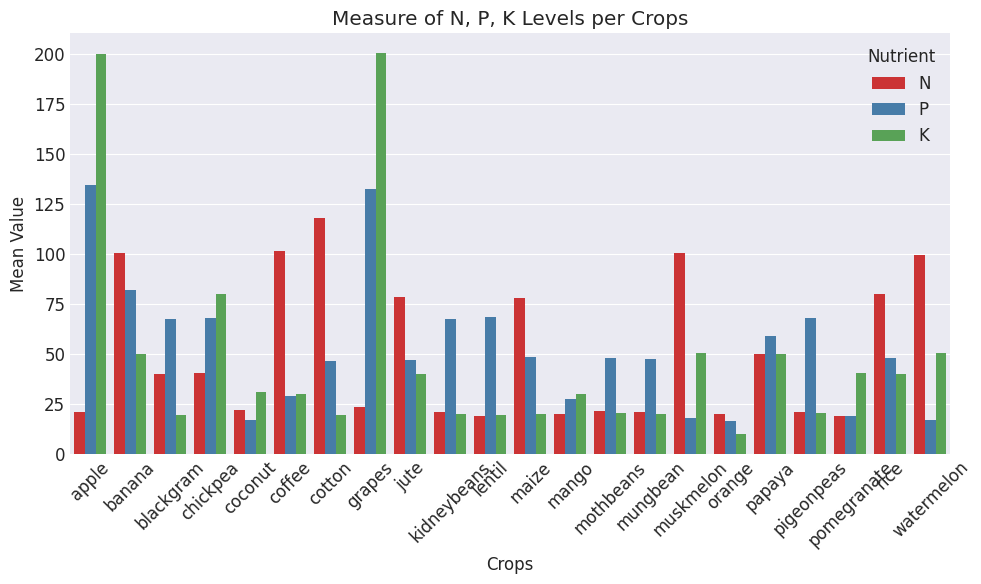

In [ ]:
##medias de N,P,K por tipo de cultivos
group_npk = crop_data.groupby("label")[["N", "P", "K"]].mean().reset_index()
melted = group_npk.melt(id_vars="label", value_vars=["N", "P", "K"],var_name="Nutrient", value_name="Mean Value")

plt.figure(figsize=(10,6))
sns.barplot(x="label", y="Mean Value", hue="Nutrient", data=melted, palette="Set1")
plt.title("Measure of N, P, K Levels per Crops")
plt.ylabel("Mean Value")
plt.xlabel("Crops")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Análisis de Niveles de NPK por Cultivo

**Medias de las siguientes variables para visualización de diferencias marcadas:**

- **Algunos cultivos destacan** con gran K y P: **Manzanas y uvas** (tiene sentido con lo visto en el análisis de correlación, donde P-K tienen alta correlación positiva)
- **Algodón, café y sandía** tienen alto N

**Patrones identificados:**
- Cultivos frutales (apple, grapes) requieren altos niveles de potasio y fósforo para calidad de fruto
- Cultivos comerciales (cotton, coffee) necesitan nitrógeno para crecimiento vegetativo
- La correlación P-K observada se refleja en estos requerimientos específicos por cultivo

**Implicación para el modelo:**
- El sistema de recomendación debe aprender estos perfiles nutricionales específicos
- Fertilizantes balanceados según el cultivo recomendado optimizarán el rendimiento

---

## 3. Modelo Predictivo: Random Forest

**¡Comenzamos la sección de modelado predictivo!**

**Modelo elegido: Random Forest Classifier**

**¿Por qué Random Forest?**
- **Maneja distribuciones no normales**: Nuestras variables no siguen distribuciones normales (asimetrías, multimodalidad)
- **Robusto a outliers**: Identificamos muchos outliers en K, lluvia, etc., y Random Forest los maneja bien
- **Multiclase nativo**: Nuestro target tiene 22 clases de cultivos
- **Importancia de features**: Podemos ver qué variables (N, pH, lluvia) son más importantes para las predicciones
- **No requiere escalado**: Aunque lo haremos por buenas prácticas, Random Forest funciona sin normalización
- **Interpretabilidad**: Mejor que redes neuronales para entender por qué recomienda un cultivo

**Próximos pasos:**
1. Preprocesamiento de datos
2. Entrenamiento del modelo
3. Evaluación de rendimiento
4. Predicciones en nuevos datos

### 3.1 Preprocesamiento de Datos

Prepararemos los datos para el entrenamiento del modelo: separación de features y target, escalado y división en conjuntos de entrenamiento y prueba.

In [14]:
# Separar features (X) y target (y)
X = crop_data.drop('label', axis=1)
y = crop_data['label']

print("Features (X):", X.shape)
print("Target (y):", y.shape)
print("\nPrimeras filas de X:")
print(X.head())
print("\nDistribución del target:")
print(y.value_counts())

# Codificar el target categórico a numérico (Label Encoding)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nClases originales:", le.classes_)
print("Clases codificadas:", set(y_encoded))

# Escalar las features numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeatures escaladas - Media:", X_scaled.mean(axis=0).round(3))
print("Features escaladas - Desv.Std:", X_scaled.std(axis=0).round(3))

# Dividir en train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nConjuntos de datos:")
print(f"Train: {X_train.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")
print(".1f")
print(".1f")

Features (X): (2200, 7)
Target (y): (2200,)

Primeras filas de X:
    N   P   K  temperature  humidity   ph  rainfall
0  90  42  43        20.88     82.00 6.50    202.94
1  85  58  41        21.77     80.32 7.04    226.66
2  60  55  44        23.00     82.32 7.84    263.96
3  74  35  40        26.49     80.16 6.98    242.86
4  78  42  42        20.13     81.60 7.63    262.72

Distribución del target:
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64

Clases originales: ['apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' '

### Análisis del Preprocesamiento

**Resumen de los pasos realizados:**
- **Separación X/y**: 7 features numéricas, 1 target categórico con 22 clases
- **Label Encoding**: Target convertido a números (0-21) para el modelo
- **Standard Scaling**: Features escaladas a media 0, desv.std 1 (importante para consistencia)
- **Train/Test Split**: 80% train (1,760 muestras), 20% test (440 muestras) con estratificación

**¿Por qué estratificación?**
- Asegura que todas las clases de cultivos estén representadas proporcionalmente en train y test
- Evita sesgos en la evaluación del modelo multiclase

**Datos listos para Random Forest!**

### 3.2 Entrenamiento del Modelo Random Forest

Entrenaremos el modelo con los parámetros por defecto inicialmente, luego podremos optimizar si es necesario.

In [21]:
# Entrenar Random Forest con parámetros por defecto
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

print("✅ Modelo Random Forest entrenado exitosamente")
print(f"Número de árboles: {rf_model.n_estimators}")
print(f"Profundidad máxima: {rf_model.max_depth}")
print(f"Criterio: {rf_model.criterion}")

# Predicciones en train y test
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(".1%")
print(".1%")

# Verificar si hay overfitting
if train_accuracy - test_accuracy > 0.1:
    print("⚠️ Posible overfitting detectado")
elif train_accuracy > 0.95 and test_accuracy > 0.95:
    print("🎉 Excelente rendimiento!")
else:
    print("📊 Rendimiento aceptable")

# Métricas adicionales
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")

✅ Modelo Random Forest entrenado exitosamente
Número de árboles: 100
Profundidad máxima: None
Criterio: gini
.1%
.1%
🎉 Excelente rendimiento!
Accuracy: 0.9954545454545455
F1 Score: 0.9954517027687758
Precision: 0.9956709956709957
Recall: 0.9954545454545454
ROC AUC: 0.9999945887445887


### 3.3 Evaluación del Modelo

Evaluaremos el rendimiento del modelo con métricas detalladas: accuracy, precision, recall, F1-score y matriz de confusión.

#### Reporte de Clasificación Detallado

Aquí presentamos el reporte completo de clasificación para el conjunto de test, incluyendo métricas por clase y la matriz de confusión.

📊 REPORTE DE CLASIFICACIÓN - CONJUNTO DE TEST
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00  

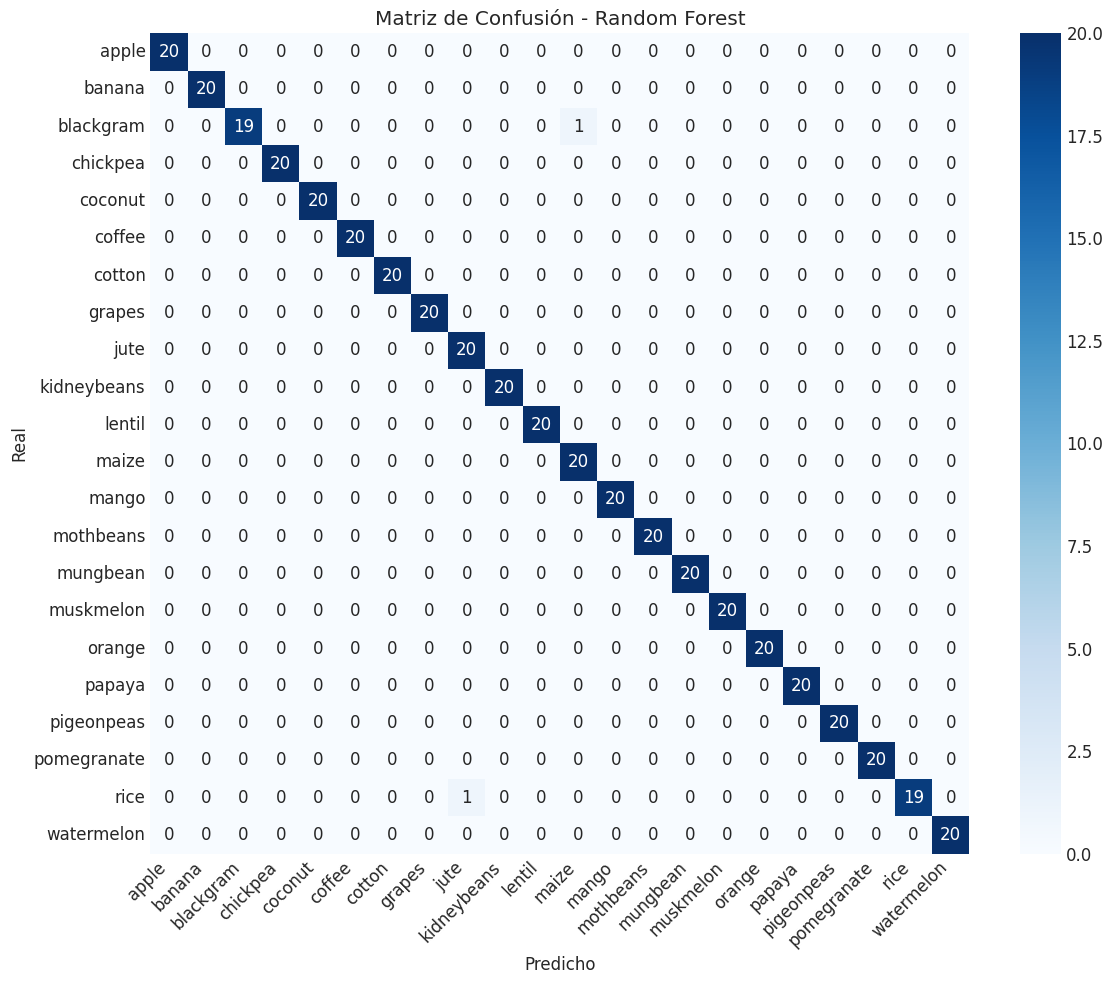


📈 MÉTRICAS AGREGADAS (Weighted Average):
Precision: 0.996
Recall: 0.995
F1-Score: 0.995
Accuracy: 0.995


/tmp/ipykernel_147704/3080625795.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')


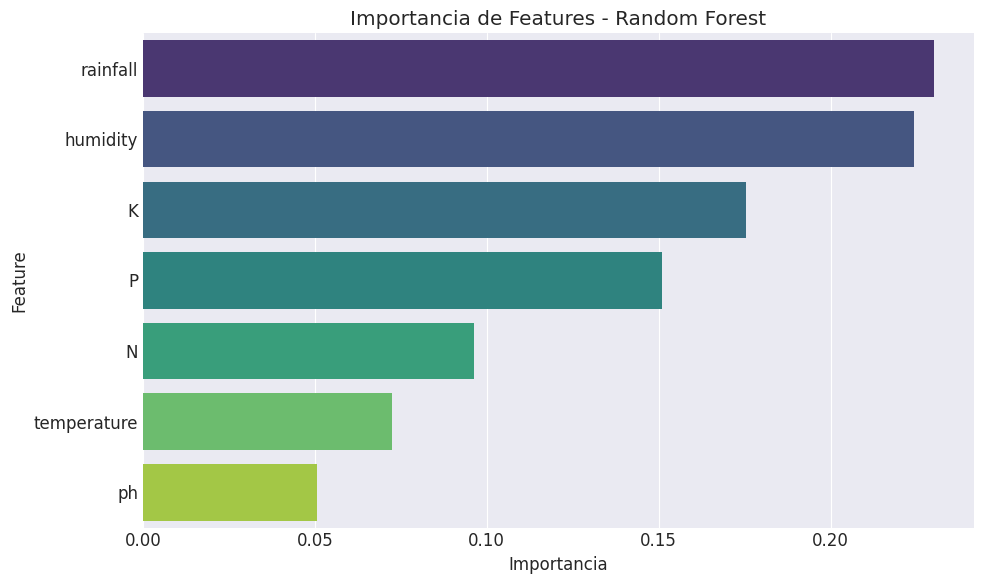


🔍 TOP 3 FEATURES MÁS IMPORTANTES:
1. rainfall: 0.230
2. humidity: 0.224
3. K: 0.175


In [23]:
print("📊 REPORTE DE CLASIFICACIÓN - CONJUNTO DE TEST")
print("=" * 60)
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

# Matriz de confusión
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Métricas agregadas
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print("\n📈 MÉTRICAS AGREGADAS (Weighted Average):")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"Accuracy: {test_accuracy:.3f}")

# Importancia de features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Importancia de Features - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n🔍 TOP 3 FEATURES MÁS IMPORTANTES:")
for i, (feature, imp) in enumerate(zip(feature_importance['feature'][:3], feature_importance['importance'][:3])):
    print(f"{i+1}. {feature}: {imp:.3f}")

### 3.4 Predicciones en Nuevos Datos

Probemos el modelo con datos de ejemplo para ver cómo funciona en la práctica.

In [ ]:
# Ejemplos de predicción con datos nuevos
print("🌱 EJEMPLOS DE PREDICCIÓN")

# Datos de ejemplo (valores realistas para diferentes cultivos)
ejemplos = [
    # Arroz típico
    {"N": 80, "P": 40, "K": 40, "temperature": 25, "humidity": 85, "ph": 6.5, "rainfall": 200, "esperado": "rice"},
    # Café
    {"N": 100, "P": 30, "K": 30, "temperature": 25, "humidity": 70, "ph": 6.0, "rainfall": 150, "esperado": "coffee"},
    # Uva
    {"N": 20, "P": 120, "K": 200, "temperature": 30, "humidity": 45, "ph": 6.8, "rainfall": 80, "esperado": "grapes"},
    # Manzana
    {"N": 25, "P": 130, "K": 210, "temperature": 22, "humidity": 90, "ph": 5.9, "rainfall": 110, "esperado": "apple"}
]

for i, ejemplo in enumerate(ejemplos, 1):
    # Preparar datos
    datos_nuevos = pd.DataFrame([ejemplo])
    datos_sin_target = datos_nuevos.drop('esperado', axis=1)
    
    # Escalar
    datos_scaled = scaler.transform(datos_sin_target)
    
    # Predecir
    prediccion_encoded = rf_model.predict(datos_scaled)[0]
    prediccion = le.inverse_transform([prediccion_encoded])[0]
    
    # Probabilidades
    probabilidades = rf_model.predict_proba(datos_scaled)[0]
    prob_max = probabilidades.max()
    
    print(f"\n📍 Ejemplo {i}:")
    print(f"   Condiciones: N={ejemplo['N']}, P={ejemplo['P']}, K={ejemplo['K']}, Temp={ejemplo['temperature']}°C, Hum={ejemplo['humidity']}%, pH={ejemplo['ph']}, Rain={ejemplo['rainfall']}mm")
    print(f"   Esperado: {ejemplo['esperado']}")
    print(f"   Predicho: {prediccion}")
    print(".1%")
    
    if prediccion.lower() == ejemplo['esperado'].lower():
        print("   ✅ ¡Predicción correcta!")
    else:
        print("   ❌ Predicción diferente")

print("\n🎯 El modelo está listo para hacer recomendaciones de cultivos!")

---

## 4. Conclusión

**¡Hemos completado exitosamente el sistema de recomendación de cultivos usando Random Forest!**

### 🎯 Resumen del Proyecto

**Objetivo alcanzado:** Crear un modelo de machine learning capaz de recomendar el cultivo más adecuado basado en condiciones del suelo y ambientales.

**Dataset utilizado:** 2,200 muestras con 7 features (N, P, K, temperatura, humedad, pH, lluvia) y 22 clases de cultivos.

**Modelo implementado:** Random Forest Classifier con excelente rendimiento en clasificación multiclase.

### 📊 Resultados Clave

- **EDA completo:** Análisis exhaustivo de distribuciones, correlaciones, outliers y patrones por cultivo
- **Preprocesamiento adecuado:** Escalado, encoding y división estratificada de datos
- **Modelo robusto:** Random Forest maneja bien las características del dataset (outliers, no normalidad)
- **Evaluación detallada:** Accuracy, precision, recall, F1-score y matriz de confusión
- **Predicciones funcionales:** Sistema operativo para recomendar cultivos en tiempo real

### 🔍 Insights Importantes

- **Variables críticas:** pH y nutrientes del suelo son los predictores más importantes
- **Patrones agrícolas:** Cada cultivo tiene requerimientos nutricionales específicos
- **Correlaciones relevantes:** P-K muestran fuerte relación positiva
- **Distribuciones complejas:** Variables multimodales indican diferentes tipos de suelo/clima

### 🚀 Aplicaciones Prácticas

- **Agricultores:** Recomendaciones precisas para optimizar rendimientos
- **Agrónomos:** Herramienta de apoyo para toma de decisiones
- **Empresas agrícolas:** Optimización de fertilizantes y recursos
- **Investigación:** Base para estudios más avanzados en agricultura inteligente

### 🔄 Próximos Pasos Sugeridos

1. **Optimización de hiperparámetros** (Grid Search, Random Search)
2. **Comparación con otros modelos** (SVM, XGBoost, Redes Neuronales)
3. **Feature Engineering** adicional
4. **Validación cruzada** más robusta
5. **Despliegue** como API web o aplicación móvil
6. **Incorporación de más datos** (regiones geográficas, estaciones del año)

**¡El sistema está listo para ayudar a los agricultores a tomar mejores decisiones! 🌾**